In [36]:
import ase.units as au
from matplotlib import pyplot as plt
import numpy as np
import os
import shutil
import sys
import subprocess

sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/apdft-ofdft-cpmd/')
import profess_io as pio

Problem 1:
- energy diverges
- lambda is not small
- N_p, N_pp are very different from 12

reasons:
- rescale density before saving?: yes seems to converge

Problem 2:
- no convergence with velocity verlet


In [48]:
class DensityOptimizer():
    
    def __init__(self):
        pass
    
    def initialize(self, workdir, dt, mu):
        self.workdir = workdir
        #dens = self.read_density(dens_file)
        #self.density = self.normalize(dens)
        #self.X = np.sqrt(self.density)
        
        #grad = self.read_gradient(grad_file)
        #self.dEdX = self.normalize(grad)
        
        self.dt = dt
        self.mu = mu
        self.energies = []
        
    def calculate_dEdX(self, density_file):
        """
        calculates dEdX for the density specified in density file
        """
        # copy density file to work_dir/density
        shutil.copy(density_file, os.path.join(self.workdir, 'density'))
        # run PROFESS-1
        self.p = self.run_profess()
        
    def calculate_lambda(self):
        Ne = 12.0
        N_p = (self.X_p*self.X).sum()
        N_pp = (self.X_p*self.X_p).sum()
        tau = self.dt**2/self.mu
        p2 = N_p/(tau*Ne)
        q = (N_pp - Ne)/(tau**2*Ne)
        lambda_1 = -p2 - np.sqrt(p2**2 - q)
        lambda_2 = -p2 + np.sqrt(p2**2 - q)
        #print(f'N_p = {N_p}, N_pp = {N_pp}')
        return(lambda_1, lambda_2)
        
    def normalize(self, dens):
        """
        multiply density with dV per voxel
        """
        V = (3.9691/au.Bohr)**3
        dV = V/16**3
        density_vox = dens*dV
        return(density_vox)
    
    def optimize(self, nsteps, density_file = None, overwrite = False):
        for i in range(nsteps):
            
            # create path to density file
            density_file = os.path.join(self.workdir, f'density_{i}')
#             if density_file == None:
#                 density_file = os.path.join(self.workdir, f'density_{i}')
#             else:
                
            # calculate gradient for density file
            self.calculate_dEdX(density_file)
            
            # read gradient and density into python
            grad_file = os.path.join(self.workdir, 'dEdX')
            grad = self.read_gradient(grad_file)
            self.dEdX = self.normalize(grad)
            dens = self.read_density(density_file)
            self.density = self.normalize(dens)
            self.X = np.sqrt(self.density)
            
            # read energy
            self.energies.append(pio.parse_out_file(os.path.join(self.workdir, 'job.out'), 'TOTAL ENERGY'))

            # propagate density
            a = -self.dEdX/self.mu
            self.X_p = a*self.dt**2 + self.X
#             if i == 0:
#                 # first step
#                 a = -self.dEdX/self.mu
#                 self.X_p = a*self.dt**2 + self.X
#             else:
#                 self.X_p = self.vv_step()
            
            # enforce that number of electrons is conserved
            lambda_1, lambda_2 = self.calculate_lambda()
            #print(f'lambda = {lambda_1}, {lambda_2}')
            self.X_p = self.X_p + self.dt**2/self.mu*lambda_2*self.X_p
            
            # write new density to file
            density_p = np.power(self.X_p,2)
            #print(f'N_pp = {density_p.sum()}')
            
            V = (3.9691/au.Bohr)**3
            dV = V/16**3
            
            density_p = density_p/dV
            #print(f'N_pp = {density_p.sum()}')
            if overwrite:
                self.save_density(density_p, os.path.join(self.workdir, f'density'))
            else:
                self.save_density(density_p, os.path.join(self.workdir, f'density_{i+1}'))
            
            # update sqrt of density for previous step
            self.X_m = self.X
            #self.X = self.X_p
    
    def read_density(self, dens_file):
        with open(dens_file, 'r') as f:
            file = f.readlines()
            density_unparsed = file[0][108:]
            density = density_unparsed.split()
            density = np.array([float(i) for i in density])
            #density = density.reshape((16,16,16))
            return(density)

    def read_gradient(self, filep):
        # load potential
        dEdX = []
        with open(filep, 'r') as f:
            for i, line in enumerate(f):
                if i != 0:
                    dEdX.append(float(line.strip('\n')))
        dEdX = np.array(dEdX)
        #dEdX = dEdX.reshape((16, 16, 16))
        return(dEdX)
    
    def run_profess(self):
        os.chdir(self.workdir)
        p = subprocess.run(['/home/misa/software/PROFESS-1/PROFESS', 'job'], capture_output = True,  text=True )
        return(p)
    
    def save_density(self, density, density_path):
        dens_str = '  x-dimension:          16   y-dimension:          16   z-dimension:          16   # of spins:            1 '
        for d in density:
            dens_str += "{:.20E} ".format(d)

        new_dens = density_path
        with open(new_dens, 'w') as f:
            f.write(dens_str)

    def vv_step(self):
        X_p = 2*self.X - self.X_m - (self.dt**2/self.mu)*self.dEdX
        return(X_p)
    

    

In [49]:
OptimizeTest = DensityOptimizer()
OptimizeTest.initialize('/home/misa/software/PROFESS-1/calculate_gradient', 0.1, 1)

In [50]:
OptimizeTest.optimize(200)

In [33]:
OptimizeTest.energies

[-231.2025715191,
 -231.2317097801,
 -231.256661708,
 -231.2782897701,
 -231.297254996,
 -231.3140678957,
 -231.329125557,
 -231.3427389504,
 -231.355153222,
 -231.3665628939,
 -231.3771233292,
 -231.3869594302,
 -231.396172276,
 -231.4048442133,
 -231.4130427813,
 -231.4208237516,
 -231.4282334948,
 -231.4353108305,
 -231.4420884815,
 -231.4485942206,
 -231.4548517801,
 -231.4608815762,
 -231.4667012884,
 -231.4723263247,
 -231.4777701983,
 -231.4830448314,
 -231.4881608044,
 -231.4931275584,
 -231.4979535631,
 -231.5026464542,
 -231.507213148,
 -231.5116599374,
 -231.5159925717,
 -231.5202163238,
 -231.5243360474,
 -231.5283562252,
 -231.5322810106,
 -231.5361142627,
 -231.5398595773,
 -231.5435203127,
 -231.5470996135,
 -231.55060043,
 -231.5540255357,
 -231.5573775436,
 -231.5606589189,
 -231.5638719919,
 -231.5670189682,
 -231.5701019387,
 -231.5731228885,
 -231.5760837039,
 -231.5789861804,
 -231.5818320282,
 -231.5846228787,
 -231.5873602891,
 -231.5900457477,
 -231.5926806782,


In [51]:
dE = []
for i in range(len(OptimizeTest.energies)-1):
    dE.append(OptimizeTest.energies[i] - OptimizeTest.energies[i+1])

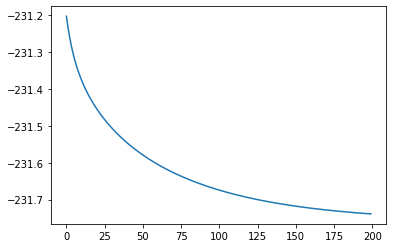

In [52]:
plt.plot(OptimizeTest.energies)

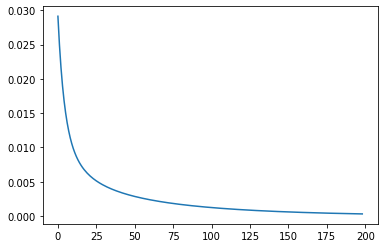

In [53]:
plt.plot(dE)

In [56]:
Eh = np.array([-8.4965386685E+00, -8.5165505320E+00, -8.5170003626E+00, -8.5170482810E+00, -8.5170492080E+00, -8.5170492795E+00])
E_eV = au.Hartree*Eh

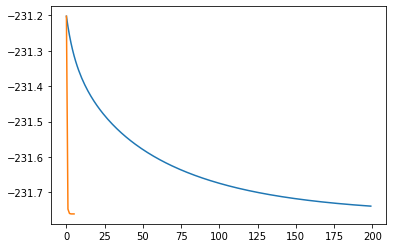

In [57]:
plt.plot(OptimizeTest.energies)
plt.plot(E_eV)

In [ ]:
density_path = '/home/misa/software/PROFESS-1/calculate_gradient/density_0'
gradient_path = '/home/misa/software/PROFESS-1/calculate_gradient/dEdX_0'
#density_m_path = '/home/misa/software/PROFESS-1/calculate_gradient/density_0'

mu = 1
dt = 0.1

In [ ]:
density = read_density(density_path)
density_normalized = normalize(density)
X = np.sqrt(density_normalized)

gradient_not_normalized = read_gradient(gradient_path)
dEdX = normalize(gradient)

In [ ]:
if step == 0:
    # propagate density  first step
    a = -dEdX/mu
    X_p = a*dt**2 + X
else:
    read_density()

### generate start density
- run PROFESS for one step
- print density -> initial guess
- see /home/misa/git_repositories/PROFESS/test/single_iteration

### call profess-1
- copy intial density
- call profess-1
- do it from python

### propagate density
- load density and gradient into python
- reshape
- propagate (with velocity verlet)

In [ ]:
def load_density(dens_file):
    with open(dens_file, 'r') as f:
        file = f.readlines()
        density_unparsed = file[0][108:]
        density = density_unparsed.split()
        density = np.array([float(i) for i in density])
        density = density.reshape((16,16,16))
        return(density)

In [ ]:
density = load_density('/home/misa/software/PROFESS-1/calculate_gradient/density_0')
density2 = load_density('/home/misa/software/PROFESS-1/calculate_gradient/new_density_test')
np.array_equal(density, density2)

In [ ]:
# load gradient
filep = '/home/misa/software/PROFESS-1/calculate_gradient/dEdX'
dEdX = []
with open(filep, 'r') as f:
    for i, line in enumerate(f):
        if i != 0:
            dEdX.append(float(line.strip('\n')))
dEdX = np.array(dEdX)
dEdX = dEdX.reshape((16, 16, 16))

In [ ]:
# what are the units of density and dE/dX?
import ase.units as au
V = (3.9691/au.Bohr)**3
dV = V/16**3
density_vox = density*dV
dEdX_vox = dEdX*dV

In [ ]:
print((density*dV).sum())
print("Density must be converted to Voxel/Bohr^3")

#### What are appropiate values for mu and dt?
- $\mu = 1$ and $dt = 0.1$ (both in a.u.) (10.1103/physrevlett.55.2471)

In [ ]:
mu = 1
dt = 0.1

In [ ]:
# propagate density  first step
a = -dEdX_vox/mu
x_1 = a*dt**2 + np.sqrt(density_vox)

In [ ]:
# propagate density velocity verlet
def vv_step(X, X_m, dt, mu, dEdX):
    X_p = 2*X - X_m - (dt**2/mu)*dEdX
    return(X_p)

# load density from previous step
dens_prev = load_density('/home/misa/software/PROFESS-1/calculate_gradient/density_0')
dens_prev = dens_prev*dV
X_minus = np.sqrt(dens_prev)
X = np.sqrt(density_vox)

In [ ]:
x_1 = vv_step(X, X_minus, dt, mu, dEdX_vox)

### enforce constraint

In [ ]:
Ne = 12.0
N_p = (x_1*np.sqrt(density_vox)).sum()
N_pp = (x_1*x_1).sum()
tau = dt**2/mu

In [ ]:
p2 = N_p/(tau*Ne)
q = (N_pp - Ne)/(tau**2*Ne)
lambda_2 = -p2 + np.sqrt(p2**2 - q)

In [ ]:
x_1_constr = x_1 + dt**2/mu*lambda_2*x_1
density_1 = np.power(x_1_constr,2)

In [ ]:
density_1.sum()

### save new density

In [ ]:
start_str = '  x-dimension:          16   y-dimension:          16   z-dimension:          16   # of spins:            1 '
density_1_fl = density_1.flatten()/dV
for d in density_1_fl:
    start_str += "{:.20E} ".format(d)
    
new_dens = '/home/misa/software/PROFESS-1/calculate_gradient/new_density'
with open(new_dens, 'w') as f:
    f.write(start_str)

In [ ]:
# start_str = '  x-dimension:          16   y-dimension:          16   z-dimension:          16   # of spins:            1 '
# density_1_fl = density.flatten()
# length = len(start_str)
# for d in density_1_fl:
#     start_str += "{:.20E} ".format(d)
#     length += len(str(d)) + 1
    
# new_dens = '/home/misa/software/PROFESS-1/calculate_gradient/new_density_test'
# with open(new_dens, 'w') as f:
#     f.write(start_str)
#     #f.write('\n')

In [ ]:
#len('0.62344209078022891357E-02')
#len('3.04456931547079749645E-02')